In [2]:
#Import all the necessary modules
import pandas as pd
import numpy as np
from scipy import stats
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn import model_selection
from sparsesvd import sparsesvd
from scipy.sparse import csc_matrix

%matplotlib inline

In [3]:
ratings = pd.read_csv("ratings_electronics.csv", sep=",", error_bad_lines=False, encoding="latin-1")
ratings.columns = ['userid', 'productid', 'rating', 'timestamp']

In [4]:
ratings.head(5)

,userid,productid,rating,timestamp
0,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
1,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
2,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
3,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200
4,A1QGNMC6O1VW39,0511189877,5.0,1397433600


In [5]:
ratings.shape

(7824481, 4)

In [6]:
# Dropping timestamp column as it is not needed for recommendation
ratings.drop('timestamp', axis=1, inplace=True)

In [7]:
users_cnt = len(ratings.userid.unique())
print('Number of unique users: ', users_cnt)

Number of unique users:  4201696


In [8]:
products_cnt = len(ratings.productid.unique())
print('Number of unique products: ', products_cnt)

Number of unique products:  476001


In [9]:
ratings.rating.unique()

array([5., 1., 3., 2., 4.])

In [10]:
prd_features = ratings.groupby('productid').agg({'userid':'count','rating':'mean'})
prd_features['productid'] = prd_features.index
prd_features.index.rename('index',inplace=True)
prd_features['no_of_ratings'] = prd_features.userid
prd_features['avg_rating'] = prd_features.rating
prd_features.drop(['userid','rating'],axis=1,inplace=True)
prd_features.head()

,productid,no_of_ratings,avg_rating
index,,,
0321732944,0321732944,1,5.000000
0439886341,0439886341,3,1.666667
0511189877,0511189877,6,4.500000
0528881469,0528881469,27,2.851852
0558835155,0558835155,1,3.000000


In [11]:
print('Maximum number of ratings a Product received:', prd_features.no_of_ratings.max())
print('Minimum rating a Product could receive is 1')
print(len(prd_features.no_of_ratings.unique()))

Maximum number of ratings a Product received: 18244
Minimum rating a Product could receive is 1
1493


In [12]:
prd_features.sort_values(by=['no_of_ratings'], ascending=False)

,productid,no_of_ratings,avg_rating
index,,,
B0074BW614,B0074BW614,18244,4.491504
B00DR0PDNE,B00DR0PDNE,16454,3.931020
B007WTAJTO,B007WTAJTO,14172,4.424005
B0019EHU8G,B0019EHU8G,12285,4.754497
B006GWO5WK,B006GWO5WK,12226,4.314657
B003ELYQGG,B003ELYQGG,11617,4.392528
B003ES5ZUU,B003ES5ZUU,10276,4.704749
B007R5YDYA,B007R5YDYA,9907,4.690926
B00622AG6S,B00622AG6S,9823,4.420136


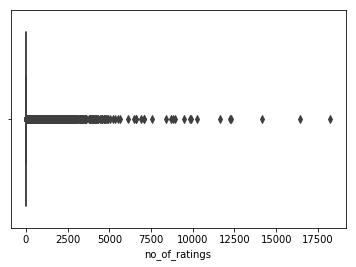

In [13]:
sns.boxplot(prd_features.no_of_ratings)

C:\AIML\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


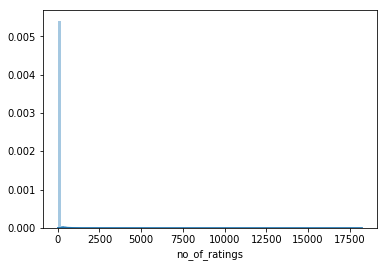

In [14]:
sns.distplot(prd_features.no_of_ratings, bins=100)

In [15]:
# Considering the boxplot and distribution plot. Number of ratings received by a product is not normally distributed. 
# It's heavily skewed

In [16]:
print('More than 25 users rated ', len(prd_features[prd_features.no_of_ratings > 25]), ' products')
print('Less than 25 users rated ', len(prd_features[prd_features.no_of_ratings <= 25]), ' products')

More than 25 users rated  46553  products
Less than 25 users rated  429448  products


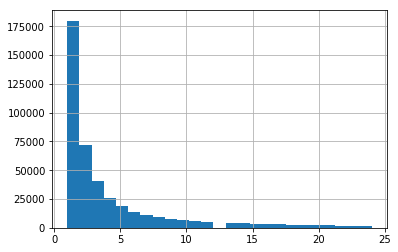

In [17]:
prd_features[prd_features.no_of_ratings < 25].no_of_ratings.hist(bins=25)

In [18]:
usr_ratings = ratings.groupby('userid').agg({'productid':'count','rating':'mean'})
usr_ratings['userid'] = usr_ratings.index
usr_ratings.index.rename('index',inplace=True)
usr_ratings['no_of_products'] = usr_ratings.productid
usr_ratings['avg_rating'] = usr_ratings.rating
usr_ratings.drop(['productid','rating'],axis=1,inplace=True)
usr_ratings.head()

,userid,no_of_products,avg_rating
index,,,
A00000262KYZUE4J55XGL,A00000262KYZUE4J55XGL,1,5.0
A000063614T1OE0BUSKUT,A000063614T1OE0BUSKUT,2,5.0
A00009182QVLSWIGHLS1B,A00009182QVLSWIGHLS1B,1,5.0
A00009661LC9LQPGKJ24G,A00009661LC9LQPGKJ24G,1,5.0
A00010809P09NUU6ZP6H,A00010809P09NUU6ZP6H,1,5.0


In [19]:
print('Maximum number of products a user has rated:', usr_ratings.no_of_products.max())
print('Minimum number a user could rate is 1')
print(len(usr_ratings.no_of_products.unique()))

Maximum number of products a user has rated: 520
Minimum number a user could rate is 1
215


In [20]:
usr_ratings.sort_values(by=['no_of_products'], ascending=False)

,userid,no_of_products,avg_rating
index,,,
A5JLAU2ARJ0BO,A5JLAU2ARJ0BO,520,3.861538
ADLVFFE4VBT8,ADLVFFE4VBT8,501,4.283433
A3OXHLG6DIBRW8,A3OXHLG6DIBRW8,498,4.451807
A6FIAB28IS79,A6FIAB28IS79,431,4.183295
A680RUE1FDO8B,A680RUE1FDO8B,406,4.406404
A1ODOGXEYECQQ8,A1ODOGXEYECQQ8,380,4.305263
A36K2N527TXXJN,A36K2N527TXXJN,314,4.525478
A2AY4YUOX2N1BQ,A2AY4YUOX2N1BQ,311,4.559486
AWPODHOB4GFWL,AWPODHOB4GFWL,308,4.392857


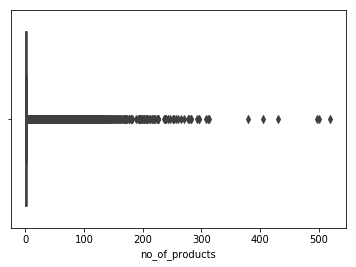

In [21]:
sns.boxplot(usr_ratings.no_of_products)

C:\AIML\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


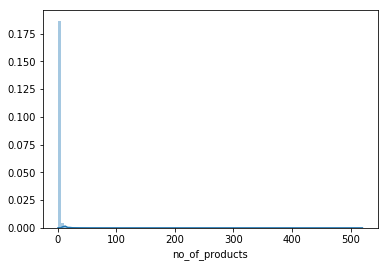

In [22]:
sns.distplot(usr_ratings.no_of_products, bins=100)

In [23]:
# Looks like most of users rated less than 50 products.

In [24]:
print('More than 20 products are rated by ', len(usr_ratings[usr_ratings.no_of_products > 20]), ' users')
print('Less than 20 products are rated by ', len(usr_ratings[usr_ratings.no_of_products <= 20]), ' users')

More than 20 products are rated by  12011  users
Less than 20 products are rated by  4189685  users


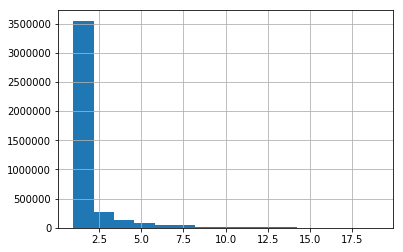

In [25]:
usr_ratings[usr_ratings.no_of_products < 20].no_of_products.hist(bins=15)

In [26]:
# For the ease of computation, we can consider users who rated more than 15 products.
data_cnt = np.array([0,1,2,3,4])
data_cnt[0] = len(ratings[ratings.userid.isin(usr_ratings[usr_ratings.no_of_products > 15].userid)])
data_cnt[1] = len(ratings[ratings.userid.isin(usr_ratings[usr_ratings.no_of_products > 25].userid)])
data_cnt[2] = len(ratings[ratings.userid.isin(usr_ratings[usr_ratings.no_of_products > 40].userid)])
data_cnt[3] = len(ratings[ratings.userid.isin(usr_ratings[usr_ratings.no_of_products > 50].userid)])
data_cnt[4] = len(ratings[ratings.userid.isin(usr_ratings[usr_ratings.no_of_products > 60].userid)])
data_cnt

array([608272, 318793, 169506, 122171,  93716])

In [27]:
# Choosing no of products as 60
ratings_df = ratings[ratings.userid.isin(usr_ratings[usr_ratings.no_of_products > 60].userid)]

### Splitting data into train and test data (70:30 ratio)

In [28]:
train_data, test_data = model_selection.train_test_split(ratings_df, test_size = 0.30, random_state=None)

In [29]:
train_data.head(10)

,userid,productid,rating
6113007,A22CW0ZHY3NJH8,B0088PPFP4,3.0
61045,A231WM2Z2JL0U3,B00004XO1V,5.0
5140980,A1EXGL6L0QQ0M5,B005PSTV2K,4.0
7268504,A30R8VFR16RE32,B00CIRLJPI,4.0
7543962,A4WEZJOIZIV4U,B00EL8NJ82,4.0
2854093,A2XRMQA6PJ5ZJ8,B002TMRZOQ,5.0
6205624,A22I55P15NSAOX,B008F537KC,1.0
1715880,A1YN5I4FINMBTI,B0015DYMVO,5.0
4850508,A14I1F2H7NOYDC,B005DIRI6I,5.0
7583579,A3AYSYSLHU26U9,B00EZL1JQE,5.0


### Polularity Recommender Model

In [30]:
# Here no_of_ratings is the score
# Giving a Rank to the entire product list. This rank will be used in determining the accuracy of the model
actual_data_rank = ratings_df.groupby('productid').agg({'userid':'count'})
actual_data_rank['productid'] = actual_data_rank.index
actual_data_rank.index.rename('index',inplace=True)
actual_data_rank['no_of_ratings'] = actual_data_rank.userid
actual_data_rank.drop(['userid'],axis=1,inplace=True)
actual_data_rank = actual_data_rank.sort_values(['no_of_ratings', 'productid'], ascending = [0,1])
actual_data_rank['rank'] = actual_data_rank['no_of_ratings'].rank(ascending=0, method='first')
actual_data_rank.head(10)

,productid,no_of_ratings,rank
index,,,
B0088CJT4U,B0088CJT4U,164,1.0
B003ES5ZUU,B003ES5ZUU,134,2.0
B000N99BBC,B000N99BBC,123,3.0
B00829TIEK,B00829TIEK,120,4.0
B002R5AM7C,B002R5AM7C,116,5.0
B008DWCRQW,B008DWCRQW,112,6.0
B007WTAJTO,B007WTAJTO,105,7.0
B00829THK0,B00829THK0,105,8.0
B004CLYEDC,B004CLYEDC,90,9.0


In [66]:
# Now for the popularity model creating rank for train data
train_data_rank = train_data.groupby('productid').agg({'userid':'count'})
train_data_rank['productid'] = train_data_rank.index
train_data_rank.index.rename('index',inplace=True)
train_data_rank['no_of_ratings'] = train_data_rank.userid
train_data_rank.drop(['userid'],axis=1,inplace=True)
train_data_rank = train_data_rank.sort_values(['no_of_ratings', 'productid'], ascending = [0,1])
train_data_rank['rank'] = train_data_rank['no_of_ratings'].rank(ascending=0, method='first')
train_data_rank.head(10)

,productid,no_of_ratings,rank
index,,,
B0088CJT4U,B0088CJT4U,109,1.0
B003ES5ZUU,B003ES5ZUU,94,2.0
B00829TIEK,B00829TIEK,91,3.0
B000N99BBC,B000N99BBC,90,4.0
B008DWCRQW,B008DWCRQW,82,5.0
B002R5AM7C,B002R5AM7C,80,6.0
B007WTAJTO,B007WTAJTO,71,7.0
B00829THK0,B00829THK0,68,8.0
B004T9RR6I,B004T9RR6I,65,9.0


In [32]:
# Popularity rank is computed based on Train data only.
# The recommendations we get from train data is applied to all the users in test data as well

# Lets get a user from test data
user_id = test_data.userid.values[0]

# For that user also the recommendations are same as train_data_rank
user_recommendations = train_data_rank.head(10)
user_recommendations['user_id'] = user_id
cols = user_recommendations.columns.tolist()
cols = cols[-1:] + cols[:-1]    
user_recommendations = user_recommendations[cols]
user_recommendations.reset_index(inplace=True)
user_recommendations

C:\AIML\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,index,user_id,productid,no_of_ratings,rank
0,B0088CJT4U,A3NG7X4APIV649,B0088CJT4U,109,1.0
1,B003ES5ZUU,A3NG7X4APIV649,B003ES5ZUU,94,2.0
2,B00829TIEK,A3NG7X4APIV649,B00829TIEK,91,3.0
3,B000N99BBC,A3NG7X4APIV649,B000N99BBC,90,4.0
4,B008DWCRQW,A3NG7X4APIV649,B008DWCRQW,82,5.0
5,B002R5AM7C,A3NG7X4APIV649,B002R5AM7C,80,6.0
6,B007WTAJTO,A3NG7X4APIV649,B007WTAJTO,71,7.0
7,B00829THK0,A3NG7X4APIV649,B00829THK0,68,8.0
8,B004T9RR6I,A3NG7X4APIV649,B004T9RR6I,65,9.0
9,B004CLYEDC,A3NG7X4APIV649,B004CLYEDC,64,10.0


###### Calculating RMSE for Popularity Model

In [33]:
# RMSE = Sqrt( Sum of Sq(observation - prediction) / no of observations)

# As far as popularity model is concerned, the prediction will be same for all the users as it's not personalised.
# So, we can evaluate the model for different number of recommendations

def get_model_difference(actual_data, predicted_data, count, ignore_order=False):
    no_of_errors = 0
    actual_df = actual_data.head(count)
    actual_df.reset_index(inplace=True)
    
    predicted_df = predicted_data.head(count)
    predicted_df.reset_index(inplace=True)
    
    if(ignore_order == True):
        no_of_errors = count - len(predicted_df[predicted_df.productid.isin(actual_df.productid)])
    else:
        for i in range(0, count, 1):
            if(predicted_df.iloc[i].productid != actual_df.iloc[i].productid):
                no_of_errors += 1
    return no_of_errors

In [34]:
# Lets evaluate the model, if we request TOP recommendations
# Top 5, Top 10, Top 20, Top 50, Top 100

top_rec = [5,10,20,50,100]
top_cnt_error = []
for i in range(0,5,1):
    err = get_model_difference(actual_data_rank, train_data_rank, top_rec[i])
    top_cnt_error.append(err)
    err = 0

rmse_pop1 = np.sqrt(sum(np.square(top_cnt_error))/5)
rmse_pop1

47.837223999726405

In [35]:
# Lets evaluate the same model by requesting for number of recommendations, not worrying about the order (TOP)
# 5, 10, 20, 50, 100

rec = [5,10,20,50,100]
cnt_error = []
for i in range(0,5,1):
    err = get_model_difference(actual_data_rank, train_data_rank, rec[i], True)
    cnt_error.append(err)
    err = 0

rmse_pop2 = np.sqrt(sum(np.square(cnt_error))/5)
rmse_pop2

3.9749213828703582

In [36]:
# The model performs better if we dont need the top order but the top recommendations alone.

### Collaborative Filtering Model

In [37]:
user_id = train_data.userid.values[0]

#user and product identifier/column name in dataset
user_id_name = 'userid'
item_id_name = 'productid'

# Get number of unique items associated (rated/watched/read) to the user
# Get number of entire unique items in the data
def get_unique_data(data_df, user_id):
    user_data = data_df[data_df[user_id_name] == user_id]
    user_items = list(user_data[item_id_name].unique())
    print("No. of unique items associated to the user: %d" % len(user_items))
    all_items = list(train_data[item_id_name].unique())
    print("No. of unique items in the training set: %d" % len(all_items))
    return (user_items, all_items)

# Get unique users who are associated to a particular item 
def get_users_rated_item(data_df, item_id):
    item_data = data_df[data_df[item_id_name] == item_id]
    item_users = set(item_data[user_id_name].unique())
    return item_users

# Get all the users who are associated to all items of a particular user
def get_user_items_data(data_df, user_items):
    user_items_users = []
    for i in range(0, len(user_items)):
        user_items_users.append(get_users_rated_item(data_df, user_items[i]))
    return user_items_users

# Building the co-occurence matrix
def build_cooccurence_matrix(data_df, user_items, all_items, user_items_users):
    cooccurence_matrix = np.matrix(np.zeros(shape=(len(user_items), len(all_items))), float)
    for i in range(0,len(all_items)):
        item_i_data = data_df[data_df[item_id_name] == all_items[i]]
        users_i = set(item_i_data[user_id_name].unique())
            
        for j in range(0,len(user_items)):
            users_j = user_items_users[j]
            users_intersection = users_i.intersection(users_j)
            if (len(users_intersection) != 0):
                users_union = users_i.union(users_j)                    
                cooccurence_matrix[j,i] = float(len(users_intersection))/float(len(users_union))
            else:
                cooccurence_matrix[j,i] = 0
    return cooccurence_matrix

def create_item_similarity_model(data_df, user_id):
    user_items, all_items = get_unique_data(data_df, user_id)
    user_items_users = get_user_items_data(data_df, user_items)
    cooccurence_matrix = build_cooccurence_matrix(data_df, user_items, all_items, user_items_users)
    return (user_items, all_items, cooccurence_matrix)

In [38]:
def generate_top_recommendations(data_df, user_id, cooccurence_matrix, all_items, user_items, no_of_recmdn):
        #Calculate a weighted average of the scores in cooccurence matrix for all user items.
        user_sim_scores = cooccurence_matrix.sum(axis=0)/float(cooccurence_matrix.shape[0])
        user_sim_scores = np.array(user_sim_scores)[0].tolist()
 
        #Sort the indices of user_sim_scores based upon their value
        #Also maintain the corresponding score
        sort_index = sorted(((e,i) for i,e in enumerate(list(user_sim_scores))), reverse=True)
    
        #Create a dataframe from the following
        columns = [user_id_name, item_id_name, 'score', 'rank']
        
        df = pd.DataFrame(columns=columns)
        #Fill the dataframe with top number of item based recommendations
        rank = 1
        for i in range(0,len(sort_index)):
            if ~np.isnan(sort_index[i][0]) and all_items[sort_index[i][1]] not in user_items and rank <= no_of_recmdn:
                df.loc[len(df)]=[user_id,all_items[sort_index[i][1]],sort_index[i][0],rank]
                rank = rank+1
        
        #Handle the case where there are no recommendations
        if df.shape[0] == 0:
            print("The current user has no items for training the item similarity based recommendation model.")
            return -1
        else:
            return df

In [39]:
# Building the Item Similarity Model for a gicen user
user_items, all_items, cooccurence_matrix = create_item_similarity_model(train_data, user_id)

No. of unique items associated to the user: 209
No. of unique items in the training set: 30649


In [40]:
# Lets build the Item Similarity Model for the given user in actual data (entire dataset)
user_items_act, all_items_act, cooccurence_matrix_act = create_item_similarity_model(ratings_df, user_id)

No. of unique items associated to the user: 292
No. of unique items in the training set: 30649


In [41]:
# RMSE = Sqrt( Sum of Sq(observation - prediction) / no of observations)

# As tge model is built for a particular user on training and actual data
# We can check the model's prediction by comparing that with actual prediction
# So, we can evaluate the model for different number of recommendations

def get_model_difference_is(user_items, all_items, cooccurence_matrix, train_data,
                         user_items_act, all_items_act, cooccurence_matrix_act, actual_data,
                         user_id, count, ignore_order=False):
    no_of_errors = 0
    actual_df = generate_top_recommendations(actual_data, user_id, cooccurence_matrix_act, all_items_act, user_items_act, count)
    predicted_df = generate_top_recommendations(train_data, user_id, cooccurence_matrix, all_items, user_items, count)
    
    if(ignore_order == True):
        no_of_errors = count - len(predicted_df[predicted_df.productid.isin(actual_df.productid)])
    else:
        for i in range(0, count, 1):
            if(predicted_df.iloc[i].productid != actual_df.iloc[i].productid):
                no_of_errors += 1
    return no_of_errors

In [42]:
# Lets evaluate the model, if we request TOP recommendations
# Top 5, Top 10, Top 20, Top 50, Top 100

top_rec_is = [5,10,20,50,100]
top_cnt_error_is = []
for i in range(0,5,1):
    err = get_model_difference_is(user_items, all_items, cooccurence_matrix, train_data,
                         user_items_act, all_items_act, cooccurence_matrix_act, ratings_df,
                         user_id, top_rec_is[i], ignore_order=False)
    top_cnt_error_is.append(err)
    err = 0

rmse_pop_is = np.sqrt(sum(np.square(top_cnt_error_is))/5)
rmse_pop_is

49.28082791512334

In [43]:
# Lets evaluate the same model by requesting for number of recommendations, not worrying about the order (TOP)
# 5, 10, 20, 50, 100

top_rec_is = [5,10,20,50,100]
top_cnt_error_is1 = []
for i in range(0,5,1):
    err = get_model_difference_is(user_items, all_items, cooccurence_matrix, train_data,
                         user_items_act, all_items_act, cooccurence_matrix_act, ratings_df,
                         user_id, top_rec_is[i], ignore_order=True)
    top_cnt_error_is1.append(err)
    err = 0

rmse_pop_is1 = np.sqrt(sum(np.square(top_cnt_error_is1))/5)
rmse_pop_is1

18.45535152740256

### Get top - K (K = 5) recommendations

In [44]:
# Getting Top recommendations for the user from training data
df_recommendations = generate_top_recommendations(train_data, user_id, cooccurence_matrix, all_items, user_items, 5)
df_recommendations

,userid,productid,score,rank
0,A22CW0ZHY3NJH8,B00HSYS3C8,0.034478,1
1,A22CW0ZHY3NJH8,B00B5C2UDC,0.030746,2
2,A22CW0ZHY3NJH8,B007OY5V68,0.029990,3
3,A22CW0ZHY3NJH8,B00L26YDA4,0.029781,4
4,A22CW0ZHY3NJH8,B00HR3J65I,0.028909,5


In [45]:
# As the Item Similarity Model handles internally (coded that way)
# to recommend only new items by ignoring the items the given user already rated,
# we get new products only in the above recommendations

In [68]:
train_data_rank.reset_index(inplace=True)
train_data_rank.head(1)

,index,productid,no_of_ratings,rank
0,B0088CJT4U,B0088CJT4U,109,1.0


In [71]:
train_data_rank.iloc[0,1]

'B0088CJT4U'

In [80]:
# Popularity based model is a generic recommendation for all the users, we need to handle separately for getting new products
# For example, if we need to get new products in popularity based model,
# below code should do the recommendation

user_id = train_data.userid.values[0]
# For getting 5 new recommendations using popularity-based model
df = train_data_rank.head(5)
#Create a dataframe from the following
columns = [user_id_name, item_id_name, 'score', 'rank']
df = pd.DataFrame(columns=columns)

#Get unique products of given user
user_unique_items = train_data[train_data.userid == user_id].productid.unique()
#Get all unique products
all_products = train_data.productid.unique()
#Fill the dataframe with top number of popularity based recommendations
#train_data_rank.reset_index(inplace=True)
rank = 1
for i in range(0,len(train_data_rank)):
    prd_id = train_data_rank.iloc[i,1]
    if((prd_id not in user_unique_items) and rank <= 5):
        df.loc[len(df)]=[user_id,prd_id,train_data_rank.iloc[i,2],rank]
        rank = rank+1
df

,userid,productid,score,rank
0,A22CW0ZHY3NJH8,B0088CJT4U,109,1
1,A22CW0ZHY3NJH8,B00829TIEK,91,2
2,A22CW0ZHY3NJH8,B000N99BBC,90,3
3,A22CW0ZHY3NJH8,B008DWCRQW,82,4
4,A22CW0ZHY3NJH8,B002R5AM7C,80,5


### Summary

In [ ]:
# Popularity Based Recommendations:
# ---------------------------------
# The weightage was given for the number of unique ratings received by each product
# Based on that weightage, popularity was determined
# So, for all the users in the dataset, the recommendations will be the same
# As the model was built on train data, the recommendations would definitely differ from actual dataset.
# For the given products data, top 5 recommendation based on popularity based model predicted better
# As the number of recommendations increased, the RMSE were also increasing
# However, popularity based recommendations are same for all the users, it's not personalised


# Collaborative Filtering (Item similarity) Recommendations:
# ----------------------------------------------------------
# The personalised predictions were better than generic predictions
# Still, the recommendations done on training set were not good as actual recommendations
# RMSE is higher if we maintain order/rank of recommendation

# Overall, collabarative filtering model is better than Popularity based models
